In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import re
import requests
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import f_regression, RFE, SelectKBest
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [3]:
df_preprocesamiento = pd.read_csv("data/dataset_preprocesamiento.csv")

## Fase 2

### Feature Engineering

#### Creación de variables: agregaciones temporales (promedios móviles) y variables lag

In [36]:
ycol = 'Frio' 
y_obs = df_preprocesamiento[ycol].shift(1)

# Lags (ejemplos: 1, 7 y 30)
for k in [1, 7, 30]:
    df_preprocesamiento[f'{ycol}_lag{k}'] = df_preprocesamiento[ycol].shift(k)

# Promedios móviles
for w in [3, 7, 14, 30]:
    df_preprocesamiento[f'{ycol}_ma{w}'] = y_obs.rolling(window=w, min_periods=1).mean()

#### Creación de variables: dia semana, mes año y fin de semana

In [ ]:
df_preprocesamiento['fecha'] = pd.to_datetime(
    df_preprocesamiento['dia'],
    format='%Y-%m-%d',
    errors='coerce'
)

# Día de la semana: 0=Lun ... 6=Dom  (periodo=7)
dow = df_preprocesamiento['fecha'].dt.dayofweek
df_preprocesamiento['dow_sin'] = np.sin(2*np.pi * dow / 7)
df_preprocesamiento['dow_cos'] = np.cos(2*np.pi * dow / 7)

# Mes: 1..12  -> usar índice 0..11 (periodo=12)
m  = df_preprocesamiento['fecha'].dt.month
m0 = (m - 1)  # 0..11
df_preprocesamiento['mes_sin'] = np.sin(2*np.pi * m0 / 12)
df_preprocesamiento['mes_cos'] = np.cos(2*np.pi * m0 / 12)

# Fin de semana: binaario
df_preprocesamiento['dia_semana']   = df_preprocesamiento['fecha'].dt.dayofweek
df_preprocesamiento['fin_de_semana'] = df_preprocesamiento['dia_semana'].isin([5, 6]).astype(int)
df_preprocesamiento.drop(columns=['dia_semana'], inplace=True)

#### Creación de variables: ratios entre consumos de diferentes áreas e interacciones entre variables principales

In [38]:
# Interacciones entre variables principales 
# Elegimos automáticamente las TOP 5 más correlacionadas con el objetivo (en valor absoluto)
num = df_preprocesamiento.select_dtypes(include=[np.number]).copy()
base_corr = y_obs if y_obs.notna().any() else df_preprocesamiento[ycol]
candidatas = [c for c in num.columns if c != ycol and num[c].notna().any()]
top5 = (
    num[candidatas].corrwith(base_corr)
    .abs()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)

# a) Productos cruzados entre las TOP
for a, b in combinations(top5, 2):
    df_preprocesamiento[f'{a}x{b}'] = df_preprocesamiento[a] * df_preprocesamiento[b]

# b) Interacciones con señales cíclicas y fines de semana (si existen)
for cyc in ['dow_sin', 'dow_cos', 'mes_sin', 'mes_cos']:
    if cyc in df_preprocesamiento.columns:
        for c in top5:
            df_preprocesamiento[f'{c}_x_{cyc}'] = df_preprocesamiento[c] * df_preprocesamiento[cyc]

if 'fin_de_semana' in df_preprocesamiento.columns:
    for c in top5:
        df_preprocesamiento[f'{c}_x_finde'] = df_preprocesamiento[c] * df_preprocesamiento['fin_de_semana']

In [41]:
# Definición de áreas
AREAS = {
    "Elaboración": r"Elab|Elabor|Coci|Cocina|Mosto|Lauter|Macer|Paste",
    "Envasado":    r"Envas|Llen|Linea|L[2345]\b",
    "Bodega":      r"Bodega|Bodeg",
    "Servicios":   r"Servicios|Vapor|Gas|Agua|Aire|Caldera|Compres|Chiller|Sala",
    "Sala_Maq":    r"Sala.*Maq",
}

# --- Helper: división segura ---
def safe_div(a, b):
    return np.divide(a, b, out=np.zeros_like(a, dtype=float), where=(b != 0))

# Detectar columnas por área (case-insensitive) entre numéricas
num_cols = df_preprocesamiento.select_dtypes(include=[np.number]).columns
area_cols = {}
for area, pat in AREAS.items():
    regex = re.compile(pat, flags=re.IGNORECASE)
    cols = [c for c in num_cols if regex.search(c)]
    area_cols[area] = cols

# Sumar consumo por área (por fila)
area_sum = {}
for area, cols in area_cols.items():
    if cols:  # si hay columnas que matchean
        df_preprocesamiento[f'{area}_sum'] = df_preprocesamiento[cols].sum(axis=1, skipna=True)
        area_sum[area] = df_preprocesamiento[f'{area}_sum']
    else:
        # si no hay columnas, creamos sum=0 para mantener consistencia
        df_preprocesamiento[f'{area}_sum'] = 0.0
        area_sum[area] = df_preprocesamiento[f'{area}_sum']

# Total seleccionado y participaciones 
areas_presentes = list(area_sum.keys())
total_sel = sum(area_sum[a] for a in areas_presentes)
df_preprocesamiento['Consumo_Total_Areas'] = total_sel

for a in areas_presentes:
    df_preprocesamiento[f'{a}_share'] = safe_div(df_preprocesamiento[f'{a}_sum'], df_preprocesamiento['Consumo_Total_Areas'])  # entre 0 y 1

# Ratios entre áreas (parejas) 
for a, b in combinations(areas_presentes, 2):
    df_preprocesamiento[f'ratio_{a}_sobre_{b}'] = safe_div(df_preprocesamiento[f'{a}_sum'], df_preprocesamiento[f'{b}_sum'])
    df_preprocesamiento[f'ratio_{b}_sobre_{a}'] = safe_div(df_preprocesamiento[f'{b}_sum'], df_preprocesamiento[f'{a}_sum'])

# Limpieza de infinitos/NaN residuales
df_preprocesamiento = df_preprocesamiento.replace([np.inf, -np.inf], np.nan)

#### Creación de variables extras: estacionalidad y datos metereológicos

In [49]:
# Estaciones del año
m = df_preprocesamiento['fecha'].dt.month

# Índice de estación 0..3: Inv=0, Prim=1, Ver=2, Oto=3
est_idx = np.select(
    [m.isin([12, 1, 2]), m.isin([3, 4, 5]), m.isin([6, 7, 8]), m.isin([9, 10, 11])],
    [0, 1, 2, 3],
    default=np.nan
)

# Estacionalidad cíclica (periodo=4 estaciones)
df_preprocesamiento['estacion_sin'] = np.sin(2*np.pi * est_idx / 4)
df_preprocesamiento['estacion_cos'] = np.cos(2*np.pi * est_idx / 4)

# Datos metereológicos
start_date = df_preprocesamiento["fecha"].min().date().isoformat()
end_date   = df_preprocesamiento["fecha"].max().date().isoformat()

# Open-Meteo (horaria) Tecate
lat, lon = 32.56717, -116.62509 # Tecate, BC (MX)
url = (
    "https://archive-api.open-meteo.com/v1/archive"
    f"?latitude={lat}&longitude={lon}"
    f"&start_date={start_date}&end_date={end_date}"
    "&daily=temperature_2m_mean"
    "&timezone=auto"
)

data = requests.get(url, timeout=60).json()
wx_d = pd.DataFrame({
    "fecha": pd.to_datetime(data["daily"]["time"]),
    "t2m_mean_C": data["daily"]["temperature_2m_mean"],
})

# Merge
df_preprocesamiento = df_preprocesamiento.merge(wx_d, on="fecha", how="left")

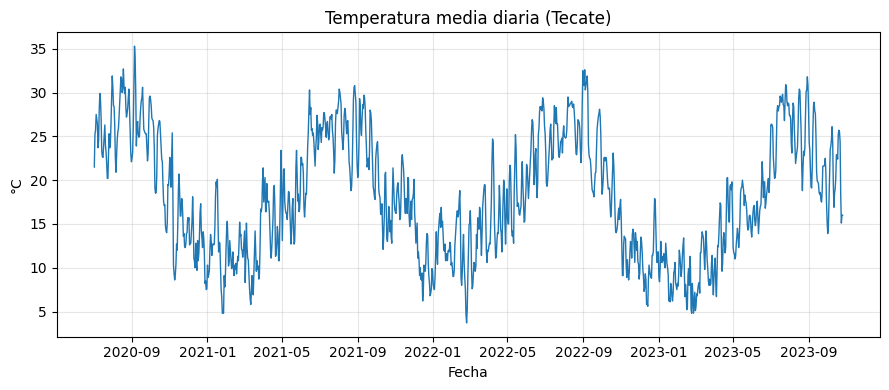

In [53]:
plt.figure(figsize=(9,4))
plt.plot(df_preprocesamiento["fecha"], df_preprocesamiento["t2m_mean_C"], linewidth=1)
plt.title("Temperatura media diaria (Tecate)")
plt.xlabel("Fecha")
plt.ylabel("°C")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [147]:
columnas_con_nulos = df_preprocesamiento.isnull().sum()[df_preprocesamiento.isnull().sum() > 0].index.tolist()
df_preprocesamiento[columnas_con_nulos] = df_preprocesamiento[columnas_con_nulos].fillna(0)

### Selección de variables

#### Selección mediante RFE, Random Forest y LASSO

el codigo de abajo tarda 5 min en ejecutarse !

In [ ]:
# ---------- preparar X, y ----------
df = df_preprocesamiento.copy()
target_col = "Frio"  
X = df.select_dtypes(include=[np.number]).drop(columns=[target_col], errors="ignore")
y = df[target_col].astype(float)

# Imputar numéricos
imp = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

k = min(50, X_imp.shape[1])  # por si tenés < 50 features

# ---------- 1) RFE con RandomForest ----------
rf_base = RandomForestRegressor(n_estimators=500, random_state=0, n_jobs=-1)
rfe = RFE(estimator=rf_base, n_features_to_select=k, step=0.1)
rfe.fit(X_imp, y)
top_rfe = list(X_imp.columns[rfe.support_])

# ---------- 2) Importancia de variables (RandomForest) ----------
rf = RandomForestRegressor(n_estimators=800, random_state=0, n_jobs=-1)
rf.fit(X_imp, y)
imp_series = pd.Series(rf.feature_importances_, index=X_imp.columns).sort_values(ascending=False)
top_rf = list(imp_series.head(k).index)

# ---------- 3) LASSO (con estandarización + CV) ----------
lasso_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("lasso", LassoCV(cv=5, random_state=0, n_jobs=-1, max_iter=5000))
])
lasso_pipe.fit(X_imp, y)
coef = pd.Series(lasso_pipe.named_steps["lasso"].coef_, index=X_imp.columns)
top_lasso = list(coef.abs().sort_values(ascending=False).head(k).index)

# ---------- resultados ----------
seleccion = {
    "RFE": top_rfe,
    "RF_importance": top_rf,
    "LASSO": top_lasso
}


# (opcional) intersección/union para análisis rápido
inter_3 = set(top_rfe) & set(top_rf) & set(top_lasso)
union_3 = set(top_rfe) | set(top_rf) | set(top_lasso)
print("Intersección de los 3 métodos:", len(inter_3))
print("Unión de los 3 métodos:", len(union_3))

c:\Users\Usuario\miniconda3\envs\cervecera_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.551e+06, tolerance: 5.197e+06
  model = cd_fast.enet_coordinate_descent_gram(


Intersección de los 3 métodos: 17
Unión de los 3 métodos: 91


Ordenamos por orden de importancia las variables de los métodos de arriba

In [132]:
# === 1) ORDENAR las seleccionadas por RFE (ranking descendente) ===
rf_final_rfe = RandomForestRegressor(n_estimators=800, random_state=0, n_jobs=-1)
rf_final_rfe.fit(X_imp[top_rfe], y)

rfe_imp = (pd.Series(rf_final_rfe.feature_importances_, index=top_rfe)
             .sort_values(ascending=False))

top_rfe_ranked = rfe_imp.index.tolist() 

# === 2) RANKING COMPLETO de Random Forest (ya tenías imp_series ordenada) ===
top_rf_ranked_all = imp_series.index.tolist()  # ranking global completo
top_rf_ranked_k   = top_rf                     # tus top-k ya ordenadas

In [133]:
# === Ranking completo por |coef| (desc) ===
coef_series = coef.copy()  # ya lo tenés del fit
lasso_ranked_all = (coef_series.abs()
                    .sort_values(ascending=False)
                    .index.tolist())

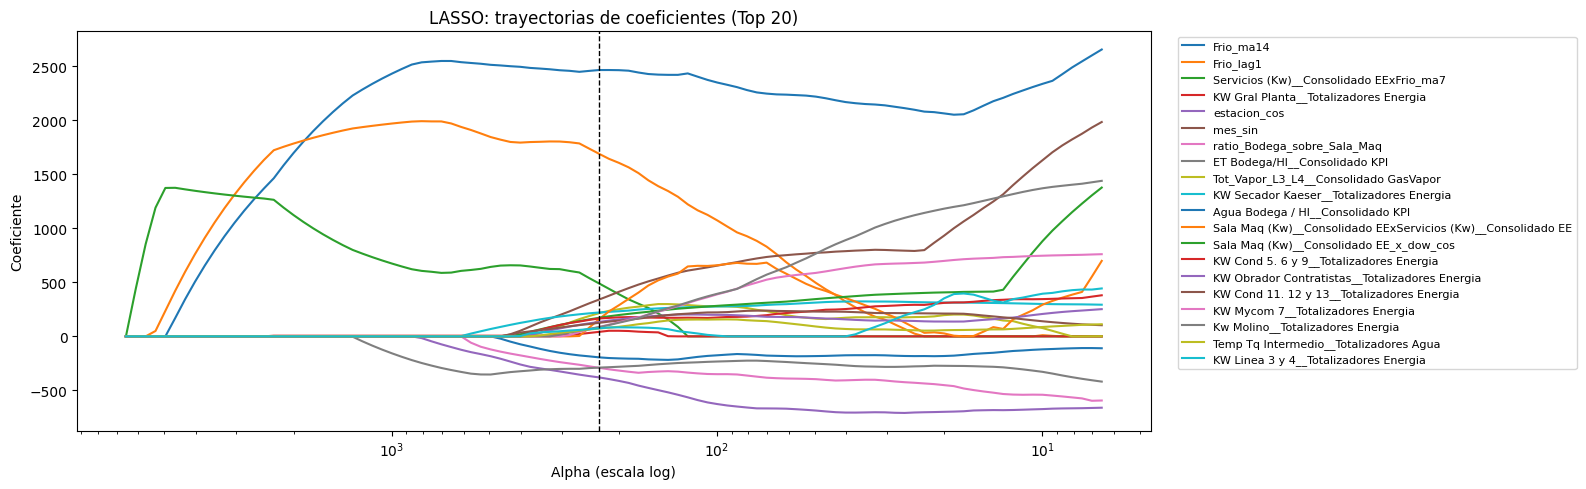

In [ ]:
from sklearn.linear_model import lasso_path

lasso_cv   = lasso_pipe.named_steps["lasso"]
scaler     = lasso_pipe.named_steps["scaler"]
alpha_best = lasso_cv.alpha_

X_std = scaler.transform(X_imp)
alphas, coefs, _ = lasso_path(X_std, y, max_iter=5000)

# ===== quedarnos con las 20 mejores (según |coef| al alpha óptimo) =====
coef_series = pd.Series(lasso_cv.coef_, index=X_imp.columns)
top20 = coef_series.abs().sort_values(ascending=False).head(20).index.tolist()

feat_idx = [list(X_imp.columns).index(f) for f in top20]

plt.figure(figsize=(16,5))
for i, f in zip(feat_idx, top20):
    plt.semilogx(alphas, coefs[i, :], label=f)

# línea vertical en alpha óptimo
plt.axvline(alpha_best, linestyle="--", linewidth=1, color="k")

plt.gca().invert_xaxis()  # alphas decrecientes -> queda “creciente” visualmente
plt.xlabel("Alpha (escala log)")
plt.ylabel("Coeficiente")
plt.title("LASSO: trayectorias de coeficientes (Top 20)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8, ncol=1)
plt.tight_layout()
plt.show()


#### Selección mediante métodos de filtro: varianza y f-test

In [ ]:
# ====== preparar datos ======
df = df_preprocesamiento.copy()
target_col = "Frio" 

X = df.select_dtypes(include=[np.number]).drop(columns=[target_col], errors="ignore")
y = df[target_col].astype(float)

k = min(50, X.shape[1])

# ====== 1) MÉTODO DE LA VARIANZA (ranking por varianza) ======
# (a) calcular varianzas ignorando NaN
vars_ = X.var(axis=0, skipna=True)
top50_varianza = list(vars_.sort_values(ascending=False).head(k).index)

# ====== 2) MÉTODO F-TEST (SelectKBest con f_regression) ======
# Imputar numéricos (mediana) para que f_regression no falle por NaN
imp = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

skb = SelectKBest(score_func=f_regression, k=k)
skb.fit(X_imp, y)

top50_ftest = list(X_imp.columns[skb.get_support()])

# ====== resultados ======
inter_2 = set(top50_varianza) & set(top50_ftest)
union_2 = set(top50_varianza) | set(top50_ftest)
print("Intersección de varianza y f-test:", len(inter_2))
print("Unión de varianza y f-test:", len(union_2))

Intersección de varianza y f-test: 17
Unión de varianza y f-test: 83


In [122]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# ===== datos =====
df = df_preprocesamiento.copy()
target_col = "Frio"  

X = df.select_dtypes(include=[np.number]).drop(columns=[target_col], errors="ignore")

# ===== imputar + escalar a [0,1] =====
imp = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

scaler = MinMaxScaler()  # mantiene varianzas comparables (todas en el mismo rango)
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=X.columns, index=X.index)

# ===== 1) FILTRO POR VARIANZA =====
print("FILTRO POR VARIANZA (umbral=0.1, datos escalados [0,1]):")
variance_selector = VarianceThreshold(threshold=0.1) # maxima varianza posible en [0,1] es 0.25
X_variance_filtered = variance_selector.fit_transform(X_scaled)
variance_features = X.columns[variance_selector.get_support()]

# ===== 2) RANKING por varianza y TOP-50 =====
var_series = X_scaled.var(axis=0, ddof=0).sort_values(ascending=False)  # varianza sobre datos escalados
top50_varianza = list(var_series.sort_values(ascending=False).head(50).index)
var_df = var_series.rename("varianza_escalada").to_frame()

print(var_df.head(16))
top_varianza = var_df.head(16).index.tolist()

FILTRO POR VARIANZA (umbral=0.1, datos escalados [0,1]):
                                              varianza_escalada
fin_de_semana                                          0.204082
KW Cond 7. 8 y 11__Totalizadores Energia               0.141424
dow_cos                                                0.138363
dow_sin                                                0.131512
mes_cos                                                0.124556
estacion_cos                                           0.124544
estacion_sin                                           0.124229
mes_sin                                                0.123590
KW Linea 3__Totalizadores Energia                      0.118709
Linea 3 (Kw)__Consolidado EE                           0.110466
Totalizador Bba P51__Totalizadores Efluentes           0.109935
Hl Cerveza L4__Totalizadores Produccion                0.109556
Hl Cerveza L4__Consolidado Produccion                  0.109556
KW Cond 5. 6 y 9__Totalizadores Energia        

#### Selección final de features